## Import Python Sklearn Libraries and NLTK


In [42]:
import csv
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, classification_report
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour

import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Get data

In [2]:
%pip install gdown
import gdown

In [3]:
#Shill
download_link = 'https://drive.google.com/u/0/uc?id=1voHIcsfEhC21yr3NA_xe7xKl6tpInJbO&export=download'

gdown.download(download_link, quiet=False)

#Conversation
download_link = 'https://drive.google.com/u/0/uc?id=1IZsujps4GcQtvV3gZGnhN67kIVIt4-Qv&export=download'

gdown.download(download_link, quiet=False)

#Special Words
download_link = 'https://drive.google.com/u/0/uc?id=1lVsDkysOK7qXeogbjbvdT8z7aziQ5oeN&export=download'

gdown.download(download_link, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1voHIcsfEhC21yr3NA_xe7xKl6tpInJbO&export=download
To: /content/shill.csv
100%|██████████| 1.40M/1.40M [00:00<00:00, 10.8MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1IZsujps4GcQtvV3gZGnhN67kIVIt4-Qv&export=download
To: /content/conversation.csv
100%|██████████| 1.40M/1.40M [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1lVsDkysOK7qXeogbjbvdT8z7aziQ5oeN&export=download
To: /content/specialWords.txt
100%|██████████| 33.3k/33.3k [00:00<00:00, 48.2MB/s]


'specialWords.txt'

## Load the dataset and remove invalid data

In [23]:
raw_data = pd.read_csv('shill.csv', sep = ';', header = None)
raw_data.columns = ["Text", "Class"]
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

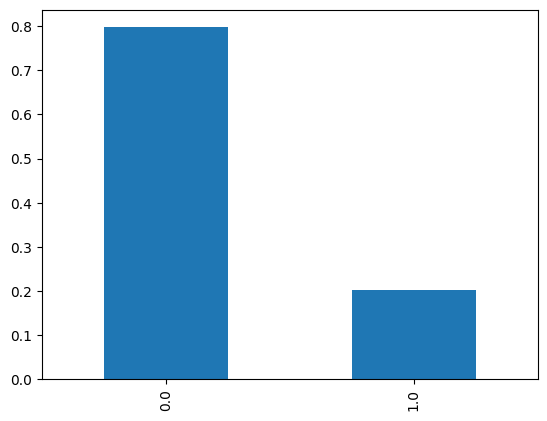

In [24]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

## Data Preprocessing

In [25]:
lemmatizer = WordNetLemmatizer()
with open('specialWords.txt') as file:
    special_words = [line.strip().lower() for line in file] # lower the special words

In [26]:
## cleaning text data, remove special charactors, numbers, puncatations, stopwords removing, lower casing, skip special words
cleaned_text = []
existing_special_words = []
for idx in range(len(raw_data)):
    sentence = raw_data['Text'][idx]
    # ignore slash "/" in punctuation removing, but if slash is not there in special words, remove it
    removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,.<>?\|`~-=_+"})
    pattern = r'[0-9]'
    new_string = re.sub(pattern, '', removeSpecialChars)
    new_string = re.sub(' +', ' ', new_string)
    new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
    existing_special_word = any(w in special_words for w in new_string.split())
    # keep slash for Special words, but if not special words, remove slash from the word
    new_string = ' '.join([lemmatizer.lemmatize(w).lower() if len(w)>1 and w.lower() not in special_words else w.replace("/", "").lower() for w in new_string.split() ] )
    cleaned_text.append(new_string)
    existing_special_words.append(existing_special_word)

raw_data['cleaned_text'] = cleaned_text
raw_data['existing'] = existing_special_words



In [27]:
raw_data.head(30)

,Text,Class,cleaned_text,existing
0,i feel lots of crypto has exhausted itself,1.0,feel lot crypto exhausted,True
1,How are you guys feeling today ??? :Bear: or ...,1.0,how guy feeling today bear bull,False
2,Did not take a trade today,1.0,did take trade today,False
3,Just entered eos long trade 👌,1.0,just entered eos long trade 👌,True
4,Anything good to buy now? Or did I miss it 😭,1.0,anything good buy or i miss 😭,False
5,GL trading tonight guys. I'm off to eat dinne...,1.0,gl trading tonight guy i'm eat dinner 🙂 watch ...,False
6,Okay my long position is still open on eth,1.0,okay long position still open eth,True
7,morning guys any trades avaiable?,1.0,morning guy trade avaiable,False
8,What’s everybodies thoughts today?,1.0,what’s everybodies thought today,False
9,Are you guys more bullish or bearish for this ...,1.0,are guy bullish bearish week,False


**how many entries were dropped after pre-processing**

In [28]:
## drop missing rows
dropped_dataset=raw_data.dropna()
dropped_dataset['Class'] = dropped_dataset['Class'].astype(int)
print("Droped samples : ", len(raw_data) - len(dropped_dataset))

Droped samples :  513


**Need to store a column specified if raw text contains Special words or not**

In [30]:
dropped_dataset['Class_Existing'] = dropped_dataset.apply(lambda row: str(row.Class) + "_" + str(row.existing), axis = 1)

In [31]:
dropped_dataset.head()

,Text,Class,cleaned_text,existing,Class_Existing
0,i feel lots of crypto has exhausted itself,1,feel lot crypto exhausted,True,1_True
1,How are you guys feeling today ??? :Bear: or ...,1,how guy feeling today bear bull,False,1_False
2,Did not take a trade today,1,did take trade today,False,1_False
3,Just entered eos long trade 👌,1,just entered eos long trade 👌,True,1_True
4,Anything good to buy now? Or did I miss it 😭,1,anything good buy or i miss 😭,False,1_False


## Data Sampling (Undersampling)

In [32]:
class_1_data = dropped_dataset[dropped_dataset["Class"] == 1]
class_0_data = dropped_dataset[dropped_dataset["Class"] == 0]

print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23211
Samples of Class 1 :  6025


## Vectorization of Text Data

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df = 0.6, min_df = 5, ngram_range = (1, 1))
tfidf = tfidf_vectorizer.fit_transform(dropped_dataset['cleaned_text'].values.astype('U'))

In [45]:
X_orig = tfidf.copy()
y_orig = dropped_dataset["Class"]

In [47]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X_orig, y_orig)

In [48]:
print(X.shape, y.shape)

(12050, 1000) (12050,)


# **Splitting into Train and Test**

In [49]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

In [ ]:
scores_data = {}
models = {}
FPs = {}


# **1. XGBoost Model**

In [50]:
xgb_pipe = Pipeline([
 ('xgb', xgb.XGBClassifier())
])
xgb_pipe.fit(X_train, y_train)
xgb_parameters = {
    'xgb__max_depth': range (2, 10, 4),
    'xgb__n_estimators': range(60, 220, 80),
    'xgb__learning_rate': [0.1, 0.01, 0.05]
}

In [51]:
# Setting up GridSearch for XGBoost
startTime = time.time()
xgb_gs = GridSearchCV(xgb_pipe, param_grid=xgb_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
xgb_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
19.08158588409424


In [52]:
xgb_gs.best_params_

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 140}

In [53]:
xgb_gs.best_score_

0.9614178674610278

In [54]:
best_xgb = xgb_gs.best_estimator_

In [55]:
with open('{}.pkl'.format("best_xgb"),'wb') as f:
      pickle.dump(best_xgb,f)

# **2. SVM Classifier**

In [56]:
svc_pipe = Pipeline([
 ('svc', svm.SVC(probability= True))
])
svc_pipe.fit(X_train, y_train)
svc_parameters = {
    'svc__probability':[True],
    'svc__C':[1,10,100], #[1,10,100,1000]
    'svc__gamma':[1,0.1,0.001,0.0001],
    'svc__kernel':['linear','rbf']
}

In [57]:
# Setting up GridSearch for SVC
startTime = time.time()
svc_gs = GridSearchCV(svc_pipe, param_grid=svc_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc')
svc_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
563.7148327827454


In [58]:
svc_gs.best_params_

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__probability': True}

In [59]:
svc_gs.best_score_

0.9623842952568887

In [60]:
best_svc = svc_gs.best_estimator_

In [61]:
with open('{}.pkl'.format("best_svc_prob"),'wb') as f:
      pickle.dump(best_svc,f)

# **3. Random Forests**

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline([
 ('rf', RandomForestClassifier())
])
rf_pipe.fit(X_train, y_train)
rf_parameters = {
    'rf__n_estimators': [200, 500],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth' : [4,5,6],
    'rf__criterion' :['gini', 'entropy']
}

In [63]:
# Setting up GridSearch for XGBoost
startTime = time.time()
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
rf_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
63.45443415641785


In [64]:
rf_gs.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 6,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500}

In [65]:
rf_gs.best_score_

0.9379336698955814

In [66]:
best_rf = rf_gs.best_estimator_

In [67]:
with open('{}.pkl'.format("best_rf"),'wb') as f:
      pickle.dump(best_rf,f)

# **4. Non-linear SVM**

In [68]:
nusvc_pipe = Pipeline([
 ('nusvc', svm.NuSVC(probability=True))
])
nusvc_pipe.fit(X_train, y_train)
nusvc_parameters = {
    'nusvc__probability':[True],
    'nusvc__nu':[0.5,1],
    'nusvc__gamma':[1,0.1]
}

In [69]:
# Setting up GridSearch for XGBoost
startTime = time.time()
nusvc_gs = GridSearchCV(nusvc_pipe, param_grid=nusvc_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
nusvc_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
63.755866289138794


In [70]:
nusvc_gs.best_params_

{'nusvc__gamma': 1, 'nusvc__nu': 0.5, 'nusvc__probability': True}

In [71]:
nusvc_gs.best_score_

0.9527107049651495

In [72]:
best_nusvc = nusvc_gs.best_estimator_

In [73]:
with open('{}.pkl'.format("best_nusvc"),'wb') as f:
      pickle.dump(best_nusvc,f)

# **5. MLPClassifier**

In [74]:
from sklearn.neural_network import MLPClassifier
mlp_pipe = Pipeline([
 ('mlp', MLPClassifier())
])
mlp_pipe.fit(X_train, y_train)
mlp_parameters = {
    'mlp__max_iter': [1000,2000],
    'mlp__hidden_layer_sizes':np.arange(10, 15)
}

In [75]:
# Setting up GridSearch for XGBoost
startTime = time.time()
mlp_gs = GridSearchCV(mlp_pipe, param_grid=mlp_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
mlp_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
478.72219467163086


In [76]:
mlp_gs.best_params_

{'mlp__hidden_layer_sizes': 13, 'mlp__max_iter': 2000}

In [77]:
mlp_gs.best_score_

0.9461666906382439

In [78]:
best_mlp = mlp_gs.best_estimator_

In [79]:
with open('{}.pkl'.format("best_mlp"),'wb') as f:
      pickle.dump(best_mlp,f)

# **6. Logistic Regression**

In [80]:
from sklearn.linear_model import LogisticRegression
lr_pipe = Pipeline([
 ('lr', LogisticRegression())
])
lr_pipe.fit(X_train, y_train)
lr_parameters = {
    'lr__penalty': ['l1','l2'],
    'lr__C': [0.001,0.01,0.1,1,10,100,1000]
}

In [81]:
# Setting up GridSearch for XGBoost
startTime = time.time()
lr_gs = GridSearchCV(lr_pipe, param_grid=lr_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
lr_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
0.8354003429412842


In [82]:
lr_gs.best_params_

{'lr__C': 10, 'lr__penalty': 'l2'}

In [83]:
lr_gs.best_score_

0.952988735681776

In [84]:
best_lr = lr_gs.best_estimator_

In [85]:
with open('{}.pkl'.format("best_lr"),'wb') as f:
      pickle.dump(best_lr,f)

# **7. GradientBoosting**

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = Pipeline([
 ('gb', GradientBoostingClassifier())
])
gb_pipe.fit(X_train, y_train)
gb_parameters = {
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3,5,8]
}

In [87]:
# Setting up GridSearch for XGBoost
startTime = time.time()
gb_gs = GridSearchCV(gb_pipe, param_grid=gb_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
gb_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
30.947471618652344


In [88]:
gb_gs.best_params_

{'gb__learning_rate': 0.1, 'gb__max_depth': 8}

In [89]:
gb_gs.best_score_

0.9597415107485096

In [90]:
best_gb = gb_gs.best_estimator_

In [91]:
with open('{}.pkl'.format("best_gb"),'wb') as f:
      pickle.dump(best_gb,f)

# **Load the XGBoost model**

In [92]:
with open('{}.pkl'.format('best_xgb'),'rb') as c_f:
  best_xgb = pickle.load(c_f)

# **Load the SVC model**

In [93]:
with open('{}.pkl'.format('best_svc_prob'),'rb') as c_f:
  best_svc = pickle.load(c_f)

# **Load the Random Forests model**

In [94]:
with open('{}.pkl'.format('best_rf'),'rb') as c_f:
  best_rf = pickle.load(c_f)

# **Load the MLP model**

In [95]:
with open('{}.pkl'.format('best_mlp'),'rb') as c_f:
  best_mlp = pickle.load(c_f)

# **Load the Non-linear SVM model**

In [96]:
with open('{}.pkl'.format('best_nusvc'),'rb') as c_f:
  best_nusvc = pickle.load(c_f)

# **Load the Logistic Regression model**

In [97]:
with open('{}.pkl'.format('best_lr'),'rb') as c_f:
  best_lr = pickle.load(c_f)

# **Load the GradientBoosting model**

In [98]:
with open('{}.pkl'.format('best_gb'),'rb') as c_f:
  best_gb = pickle.load(c_f)

In [99]:
def plot_roc_curve(models, X_test):
  plt.figure(0).clf()
  for model_name in models:
    y_pred = models[model_name].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label="{}, AUC={}".format(model_name, round(auc, 4)))
  plt.legend()

In [100]:
def plot_precision_recall_curve(models, X_test):
  plt.figure(0).clf()

  for model_name in models:
    y_proba = models[model_name].predict_proba(X_test)[:, 1]
    y_pred = models[model_name].predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_proba)
    lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
    plt.plot(lr_precision,lr_recall,label="{}, AUC={}".format(model_name, round(lr_auc, 4)))
  plt.legend()

In [101]:
## build a function to evaluate classification model
def model_evaluation(model, train, test, train_y, test_y):
    pred_train = model.predict(train)
    pred_test = model.predict(test)

    print(classification_report(test_y, pred_test))
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)

    train_recall = recall_score(train_y,pred_train, average = 'weighted')
    test_recall = recall_score(test_y,pred_test, average = 'weighted')

    train_precision = precision_score(train_y,pred_train, average = 'weighted')
    test_precision = precision_score(test_y,pred_test, average = 'weighted')

    train_f1 = f1_score(train_y,pred_train, average = 'weighted')
    test_f1 = f1_score(test_y,pred_test, average = 'weighted')

    print("\n\t\t  Train score  /  Test score\n")
    print(f"Accuracy  : {train_acc} / {test_acc}")
    print(f"Recall    : {train_recall} / {test_recall}")
    print(f"Precision : {train_precision} / {test_precision}")
    print(f"F1 Score  : {train_f1} / {test_f1}")

    cm=confusion_matrix(test_y, pred_test)
    FP = cm[0][1]
    df_cm = pd.DataFrame(cm, index = [i for i in ['class:  0', 'class : 1']],
                  columns = [i for i in ['class:  0', 'class : 1']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (8,4))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.title("\nConfusion Matrix\n", color='blue', fontsize = 16)
    plt.ylabel('\nActual\n', color='blue')
    plt.xlabel('\nPredicted\n', color = 'blue')
    plt.show()
    return [test_acc, test_recall, test_precision, test_f1], FP

In [102]:
models = {}
models["XGBoost"] = best_xgb
models["SVM Classifier"] = best_svc
models["Random Forests"] = best_rf
models["Non-linear SVM"] = best_nusvc
models["MLPClassifier"] = best_mlp
models["Logistic Regression"] = best_lr
models["GradientBoosting"] = best_gb


# **Plot ROC Curve**

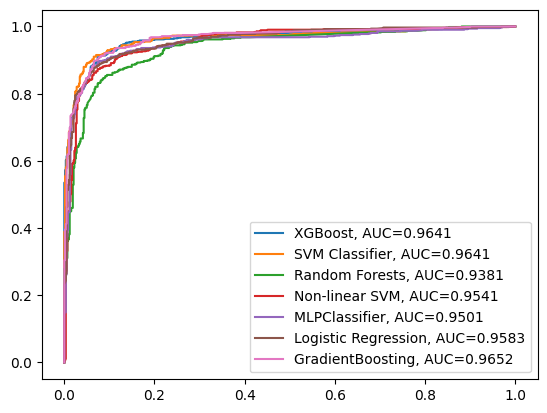

In [103]:
plot_roc_curve(models, X_test)

# **Plot PR Curve**

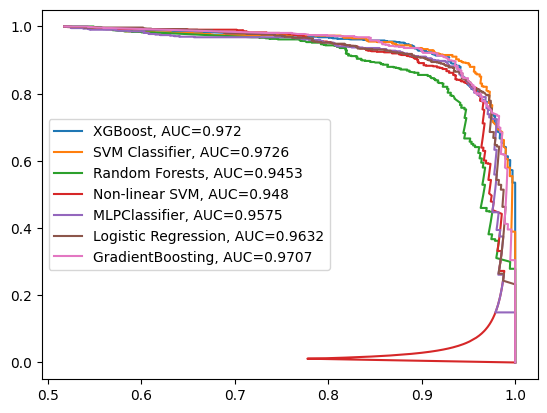

In [104]:
plot_precision_recall_curve(models, X_test)

# **Plot Model Evaluation**

In [105]:
scores_data = {}
FPs = {}


			XGBoost

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.93      0.90      0.91       624

    accuracy                           0.91      1205
   macro avg       0.91      0.91      0.91      1205
weighted avg       0.91      0.91      0.91      1205


		  Train score  /  Test score

Accuracy  : 0.9252189949285385 / 0.9103734439834025
Recall    : 0.9252189949285385 / 0.9103734439834025
Precision : 0.9253049589781022 / 0.9110373837196158
F1 Score  : 0.9252128661479984 / 0.9104019696966092


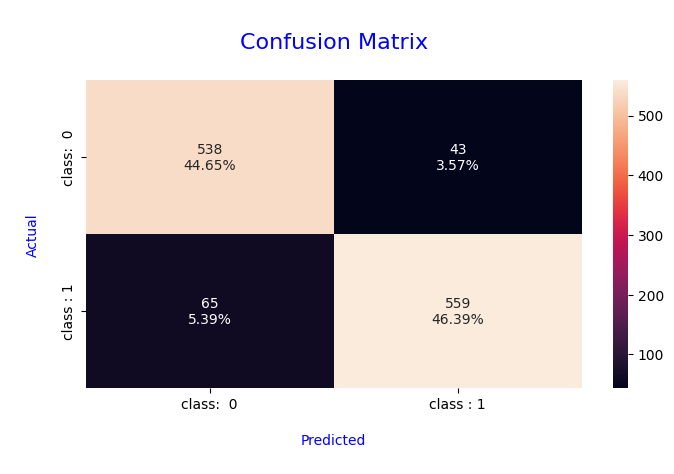


			SVM Classifier

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       581
           1       0.94      0.90      0.92       624

    accuracy                           0.92      1205
   macro avg       0.92      0.92      0.92      1205
weighted avg       0.92      0.92      0.92      1205


		  Train score  /  Test score

Accuracy  : 0.9503918856615952 / 0.9186721991701244
Recall    : 0.9503918856615952 / 0.9186721991701244
Precision : 0.9503918856615952 / 0.9194521449881693
F1 Score  : 0.9503918856615952 / 0.9186977460440421


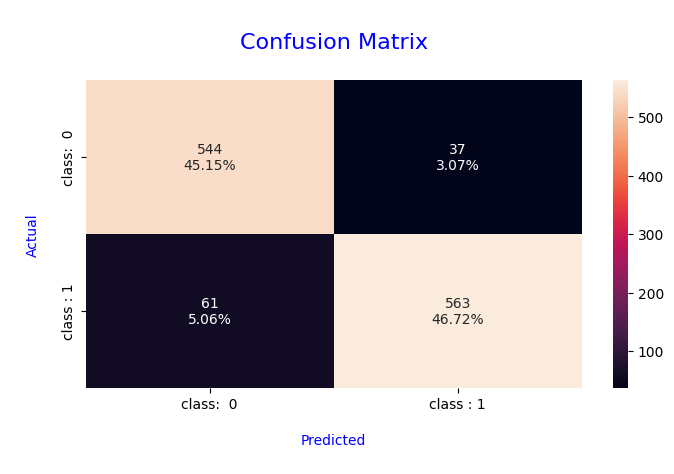


			Random Forests

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       581
           1       0.90      0.86      0.88       624

    accuracy                           0.88      1205
   macro avg       0.88      0.88      0.88      1205
weighted avg       0.88      0.88      0.88      1205


		  Train score  /  Test score

Accuracy  : 0.8822498847395113 / 0.8771784232365145
Recall    : 0.8822498847395113 / 0.8771784232365145
Precision : 0.8827281883661803 / 0.8784755771048609
F1 Score  : 0.882203398650737 / 0.8772082001329353


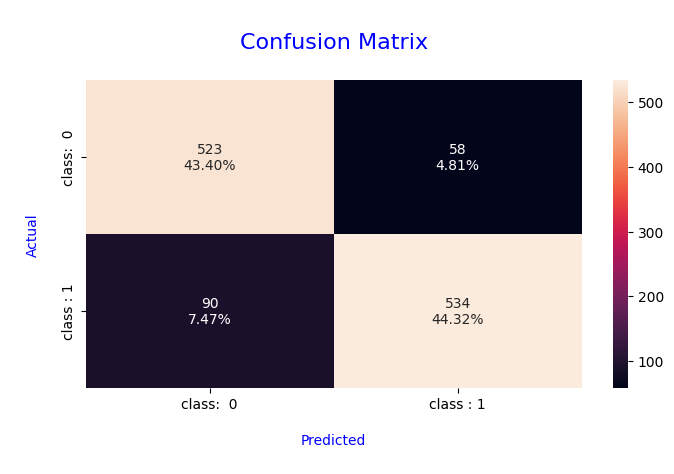


			Non-linear SVM

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       581
           1       0.93      0.87      0.90       624

    accuracy                           0.90      1205
   macro avg       0.90      0.90      0.90      1205
weighted avg       0.90      0.90      0.90      1205


		  Train score  /  Test score

Accuracy  : 0.9016136468418626 / 0.8954356846473029
Recall    : 0.9016136468418626 / 0.8954356846473029
Precision : 0.9021738833289416 / 0.8974282243166358
F1 Score  : 0.9015710959705415 / 0.8954443262310335


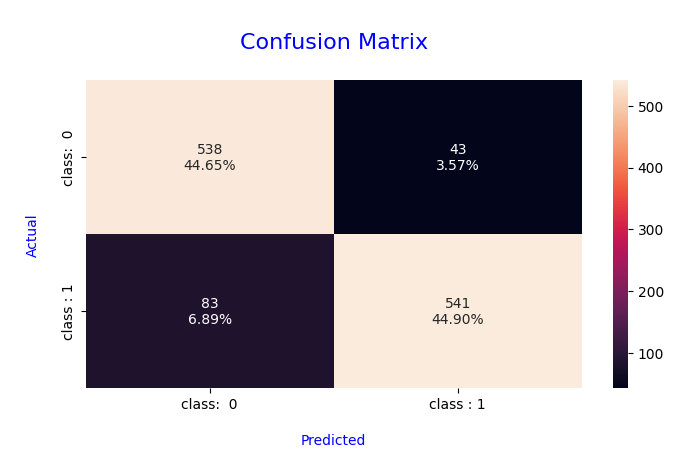


			MLPClassifier

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       581
           1       0.91      0.91      0.91       624

    accuracy                           0.90      1205
   macro avg       0.90      0.90      0.90      1205
weighted avg       0.90      0.90      0.90      1205


		  Train score  /  Test score

Accuracy  : 0.9732595666205625 / 0.9029045643153527
Recall    : 0.9732595666205625 / 0.9029045643153527
Precision : 0.9732766740055184 / 0.9029114329104764
F1 Score  : 0.9732596466504928 / 0.9029073762287249


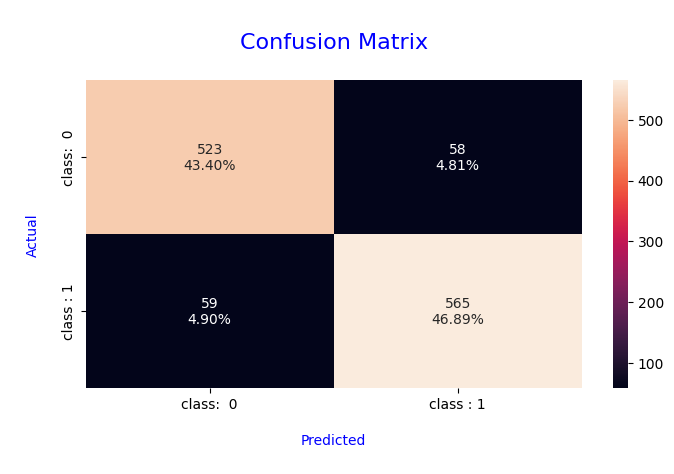


			Logistic Regression

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       581
           1       0.91      0.90      0.90       624

    accuracy                           0.90      1205
   macro avg       0.90      0.90      0.90      1205
weighted avg       0.90      0.90      0.90      1205


		  Train score  /  Test score

Accuracy  : 0.9141539880129091 / 0.9012448132780083
Recall    : 0.9141539880129091 / 0.9012448132780083
Precision : 0.9141755933445117 / 0.901272334379808
F1 Score  : 0.9141541500498814 / 0.9012529837262607


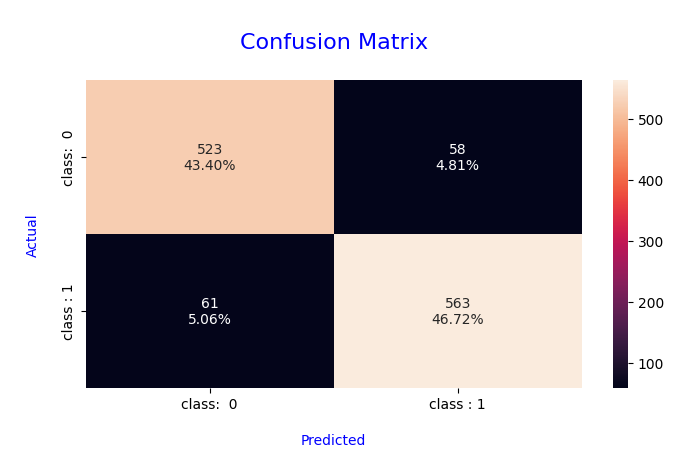


			GradientBoosting

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       581
           1       0.93      0.90      0.91       624

    accuracy                           0.91      1205
   macro avg       0.91      0.91      0.91      1205
weighted avg       0.91      0.91      0.91      1205


		  Train score  /  Test score

Accuracy  : 0.9426463808206547 / 0.9120331950207469
Recall    : 0.9426463808206547 / 0.9120331950207469
Precision : 0.9426912514828798 / 0.9125914230406843
F1 Score  : 0.9426436771042922 / 0.91206107296894


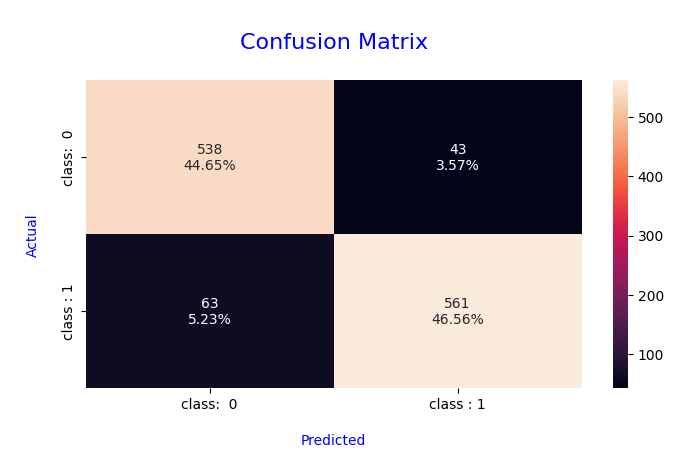

In [106]:

for model_name in models:
  print('\n\t\t\t{}\n'.format(model_name))
  score, FP = model_evaluation(models[model_name], X_train, X_test, y_train, y_test)
  scores_data[model_name] = score
  FPs[model_name] = FP

In [107]:
score_df = pd.DataFrame(scores_data).T
score_df.columns = ['accuracy', 'recall', 'precision', 'f1-score']
score_df

,accuracy,recall,precision,f1-score
XGBoost,0.910373,0.910373,0.911037,0.910402
SVM Classifier,0.918672,0.918672,0.919452,0.918698
Random Forests,0.877178,0.877178,0.878476,0.877208
Non-linear SVM,0.895436,0.895436,0.897428,0.895444
MLPClassifier,0.902905,0.902905,0.902911,0.902907
Logistic Regression,0.901245,0.901245,0.901272,0.901253
GradientBoosting,0.912033,0.912033,0.912591,0.912061


In [108]:
FP_df = pd.DataFrame.from_dict(FPs, orient='index', columns = ["FP"])
FP_df

,FP
XGBoost,43
SVM Classifier,37
Random Forests,58
Non-linear SVM,43
MLPClassifier,58
Logistic Regression,58
GradientBoosting,43


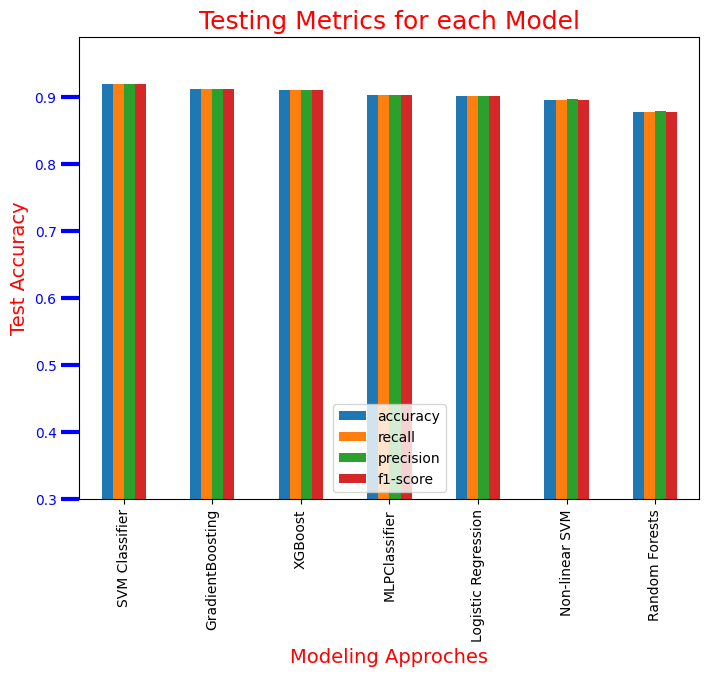

In [109]:
score_df.sort_values('accuracy',ascending = False).plot(kind='bar',figsize=(8,6))
plt.title("Testing Metrics for each Model",fontsize=18,color='red')
plt.tick_params(axis='y', colors='blue', direction='out', length=13, width=3)
plt.xlabel("Modeling Approches", fontsize=14, color = 'red')
plt.ylim([0.3, 0.99])
plt.ylabel("Test Accuracy", fontsize=14, color = 'red')
plt.show()

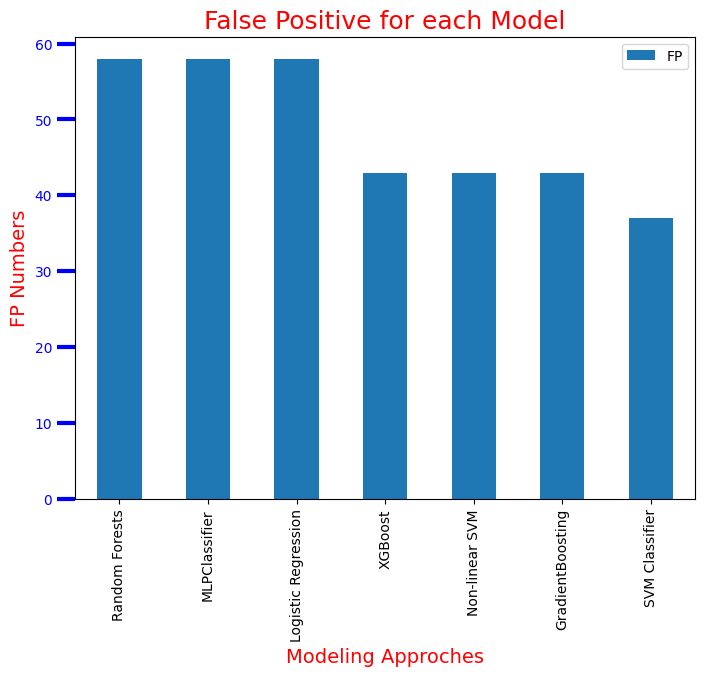

In [110]:
FP_df.sort_values('FP',ascending = False).plot(kind='bar',figsize=(8,6))
plt.title("False Positive for each Model",fontsize=18,color='red')
plt.tick_params(axis='y', colors='blue', direction='out', length=13, width=3)
plt.xlabel("Modeling Approches", fontsize=14, color = 'red')
plt.ylabel("FP Numbers", fontsize=14, color = 'red')
plt.show()